In [6]:
import numpy as np
import pandas as pd

df = pd.read_csv("TeknolojiYorumları .csv", delimiter=';')
df.head(4)

,Metin,Durum,Alan,Konu
0,Ekran kalitesi çok düşük,0,Teknoloji,ekran
1,elbise iyi,1,Moda,kalite
2,nostaljii...ekrani kucuk ama is goruyor??,1,Teknoloji,ekran
3,mükemmel ama şarjı çabuk bitiyor,2,Teknoloji,şarj


In [7]:
#Sadece metin sütunun kullanılması, konu modelleme için yeterli olacaktır.
yorum_veriseti=df[["Metin"]]
yorum_veriseti.head(4)

,Metin
0,Ekran kalitesi çok düşük
1,elbise iyi
2,nostaljii...ekrani kucuk ama is goruyor??
3,mükemmel ama şarjı çabuk bitiyor


In [8]:
konu_veriseti=df[["Konu"]]
konu_veriseti.head(4)

,Konu
0,ekran
1,kalite
2,ekran
3,şarj


In [10]:
#veri temizleme işlemi için bir fonksiyon hazırlanması

import re 
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


nok_isaretleri= string.punctuation
etkisiz_kelimeler= stopwords.words('turkish')
etkisiz_kelimeler.extend (["bir", "kadar", "sonra"])


def veriTemizleme(metin):
    metin=metin.lower()
    metin=metin.replace("\\n"," ")
    #kesme işareti ve sonrasındaki karakterlerin aldırılması
    metin=re.sub("'(\w+)'", "", metin)
    metin=re.sub("'(\w+)'", "", metin)
    #sayıların kaldırılması
    metin=re.sub("[0-9]+", "", metin)
    #noktalama işaretlerinin kaldırılması
    metin="".join(list(map(lambda x:x if x not in nok_isaretleri else " " , metin)))
    #etkisiz kelimelerin bazılarının kaldırılması
    metin=" ".join([i for i in metin.split() if i not in etkisiz_kelimeler])
    #metinde tek kalan harflerin çıkarılması
    metin=" ".join([i for i in metin.split() if len(i) > 1])

    return metin


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gülseren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Temizlenmemiş veri seti
print("Temizlenmemiş Veri Seti:")
print(df["Metin"].head(10))

# Temizlenmiş veri seti
print("\nTemizlenmiş Veri Seti:")
temizlenen_metin = yorum_veriseti["Metin"].apply(veriTemizleme)
print(temizlenen_metin.head(10))

Temizlenmemiş Veri Seti:
0                             Ekran kalitesi çok düşük
1                                           elbise iyi
2            nostaljii...ekrani kucuk ama is goruyor??
3                     mükemmel ama şarjı çabuk bitiyor
4              sesi rahatsiz ediyor ama çocuklar sevdi
5                    Ürün güzel;bataryası çok gidiyor.
6    Tam bir nostalji yaratıyor. Sesi bile yetti ba...
7    ürün çom güzel eğlenceli içerisinde 500 tane o...
8    o kadar çabuk şarjı bitiyo ki , sırf çocuğumla...
9    Bir heves aldık ama çok gereksiz, oynamak keyi...
Name: Metin, dtype: object

Temizlenmiş Veri Seti:
0                                 ekran kalitesi düşük
1                                           elbise iyi
2                    nostaljii ekrani kucuk is goruyor
3                         mükemmel şarjı çabuk bitiyor
4                  sesi rahatsiz ediyor çocuklar sevdi
5                         ürün güzel bataryası gidiyor
6          tam nostalji yaratıyor sesi bile 

In [12]:
# Tokenize etme
yorum_veriseti["temizlenen_metin_token"] = temizlenen_metin.apply(lambda x: x.split())
yorum_veriseti.head(10)

C:\Users\Gülseren\AppData\Local\Temp\ipykernel_8772\268001877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yorum_veriseti["temizlenen_metin_token"] = temizlenen_metin.apply(lambda x: x.split())


,Metin,temizlenen_metin_token
0,Ekran kalitesi çok düşük,"[ekran, kalitesi, düşük]"
1,elbise iyi,"[elbise, iyi]"
2,nostaljii...ekrani kucuk ama is goruyor??,"[nostaljii, ekrani, kucuk, is, goruyor]"
3,mükemmel ama şarjı çabuk bitiyor,"[mükemmel, şarjı, çabuk, bitiyor]"
4,sesi rahatsiz ediyor ama çocuklar sevdi,"[sesi, rahatsiz, ediyor, çocuklar, sevdi]"
5,Ürün güzel;bataryası çok gidiyor.,"[ürün, güzel, bataryası, gidiyor]"
6,Tam bir nostalji yaratıyor. Sesi bile yetti ba...,"[tam, nostalji, yaratıyor, sesi, bile, yetti, ..."
7,ürün çom güzel eğlenceli içerisinde 500 tane o...,"[ürün, çom, güzel, eğlenceli, içerisinde, tane..."
8,"o kadar çabuk şarjı bitiyo ki , sırf çocuğumla...","[çabuk, şarjı, bitiyo, sırf, çocuğumla, çocukl..."
9,"Bir heves aldık ama çok gereksiz, oynamak keyi...","[heves, aldık, gereksiz, oynamak, keyifli, değ..."


In [101]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords


konular = konu_veriseti["Konu"].tolist()

# CountVectorizer kullanarak metin vektörleştirmesi
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords.words('turkish'), max_features=1000, ngram_range=(1, 2), tokenizer=lambda x: x)
X = vectorizer.fit_transform(yorum_veriseti['Birlesik_Metin'])

# LDA modeli eğitimi
lda_model = LatentDirichletAllocation(n_components=len(set(konular)), random_state=42)
lda_topic_matrix = lda_model.fit_transform(X)


# Her yorumun en olası konusunu bulma
yorum_veriseti['Tahmin_Edilen_Konu'] = lda_topic_matrix.argmax(axis=1)

# Sonuçları gösterme
print(yorum_veriseti[['Metin', 'Tahmin_Edilen_Konu']])


c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ç', 'ü', 'ğ', 'ı', 'ş'] not in stop_words.
  warnings.warn(


                                                 Metin  Tahmin_Edilen_Konu
0                             Ekran kalitesi çok düşük                  10
1                                           elbise iyi                   3
2            nostaljii...ekrani kucuk ama is goruyor??                   2
3                     mükemmel ama şarjı çabuk bitiyor                   4
4              sesi rahatsiz ediyor ama çocuklar sevdi                   2
..                                                 ...                 ...
229     Çok gereksizmiş tuşları kalitesiz görüntü kötü                   5
230                  şarjı çok sıkıntılı ona göre alın                   0
231                                 Ekranı biraz küçük                   8
232  ürün biraz önce bana ulaştı. ekranı çizik için...                   8
233  Ürün zaten aşırı sağlam kaliteli bir şey değil...                   0

[234 rows x 2 columns]


In [73]:
yorum_veriseti['Konu'] = konu_veriseti["Konu"]
# Sonuçları gösterme
print(yorum_veriseti[["Konu"]])

       Konu
0     ekran
1    kalite
2     ekran
3      şarj
4       ses
..      ...
229  kalite
230    şarj
231   boyut
232   ekran
233  kalite

[234 rows x 1 columns]


In [74]:

print("konular:")
print(len(set(konular)))
print((set(konular)))

konular:
11
{'renk', 'boyut', 'ses', nan, 'performans', 'teslimat', 'fiyat', 'şarj,', 'şarj', 'kalite', 'ekran'}


In [56]:
#LDA'nın öğrendiği konuların terim ağırlıklarını içeren bir matrisi gösterir
print(lda_model.components_)


[[1.42732412e+02 1.47721494e+02 3.63731887e+00 ... 2.09088740e+00
  9.09172735e-02 9.09128784e-02]
 [9.09100973e-02 9.09113960e-02 9.09090912e-02 ... 9.09090913e-02
  9.09090910e-02 9.09101651e-02]
 [3.40565120e+01 7.59367226e+01 4.59968839e+01 ... 9.09126349e-02
  9.09148288e-02 9.09100336e-02]
 ...
 [3.05912679e+00 2.50202486e+01 9.09144991e-02 ... 9.09090909e-02
  9.09090909e-02 9.09105514e-02]
 [1.55044137e+01 1.98373574e-01 2.75296317e+00 ... 1.09089626e+00
  3.09088391e+00 9.09118315e-02]
 [9.09113902e-02 9.09146310e-02 3.00757449e+00 ... 9.09400639e-02
  9.09203474e-02 7.09089691e+00]]


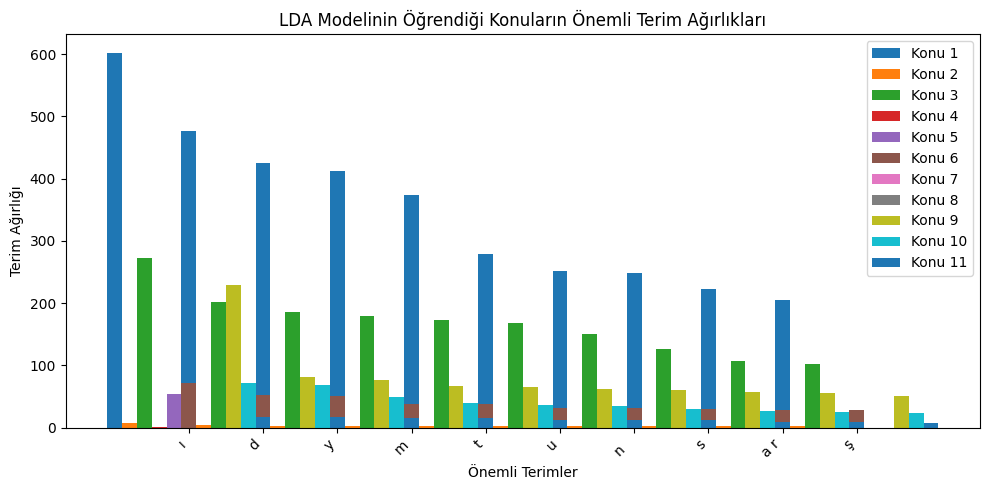

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Terim ağırlıklarını içeren matris
term_weights = lda_model.components_

# Terimlerin isimleri
feature_names = vectorizer.get_feature_names_out()

# Konu isimleri
topic_names = [f'Konu {i+1}' for i in range(lda_model.n_components)]

# Önemli terimleri seç (örneğin, en yüksek ağırlığa sahip 10 terimi al)
num_top_terms = 10
top_term_indices = term_weights.argsort(axis=1)[:, -num_top_terms:][:, ::-1]
top_terms = [[feature_names[i] for i in indices] for indices in top_term_indices]

# Bar plot çizimi
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.2
bar_positions = np.arange(num_top_terms)

for i in range(lda_model.n_components):
    ax.bar(bar_positions + i * bar_width, term_weights[i, top_term_indices[i]], bar_width, label=f'Konu {i+1}')

# Eksen etiketleri ve başlık ekle
ax.set_xticks(bar_positions + (lda_model.n_components - 1) * bar_width / 2)
ax.set_xticklabels(top_terms[0], rotation=45, ha='right')
ax.set_xlabel('Önemli Terimler')
ax.set_ylabel('Terim Ağırlığı')
ax.set_title('LDA Modelinin Öğrendiği Konuların Önemli Terim Ağırlıkları')

# Konu etiketlerini ekle
ax.legend()

plt.tight_layout()
plt.show()


In [108]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Örnek veri seti ve etiketleri
X = df['Metin']
y = df['Durum']

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vektörleştirici ve LinearSVC sınıflandırıcıyı içeren bir pipeline oluşturun
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# Grid Search için parametreler
param_grid = {
    'tfidf__max_features': [100, 500, None],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10],
}

# Grid Search ve Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# En iyi parametreleri göster
print("En İyi Parametreler:", grid_search.best_params_)

# En iyi modeli kullanarak test seti üzerinde tahmin yapın
y_pred = grid_search.predict(X_test)

# Model performansını değerlendirin
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk (Accuracy): {accuracy}")


c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress

c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set t

En İyi Parametreler: {'clf__C': 10, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        31
          0,       0.00      0.00      0.00         1
           1       1.00      0.40      0.57         5
           2       0.44      0.40      0.42        10
 2,Teknoloji       0.00      0.00      0.00         0

    accuracy                           0.70        47
   macro avg       0.44      0.33      0.36        47
weighted avg       0.71      0.70      0.69        47

Doğruluk (Accuracy): 0.7021276595744681


c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471:

In [78]:
# Yeni gelen yorumları içeren bir veri çerçevesi oluşturma
yeni_yorumlar = pd.DataFrame({
    'Metin': ['Ekranı kırık geldi', 'Şarj süresi çok kısa.'],
    'Durum': [0, 1],
    'Alan': ['Teknoloji', 'Teknoloji']
})

# Yeni gelen yorumları temizleme
yeni_yorumlar['temizlenen_metin_token'] = yeni_yorumlar['Metin'].apply(lambda x: ' '.join([word.lower() for word in nltk.word_tokenize(x) if word.isalpha()]))

# CountVectorizer kullanarak metin vektörleştirmesi
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords.words('turkish'), max_features=1000, ngram_range=(1, 2), tokenizer=lambda x: x)
X = vectorizer.fit_transform(yorum_veriseti['temizlenen_metin_token'])

# LDA modeli eğitimi
lda_model = LatentDirichletAllocation(n_components=len(set(yorum_veriseti['Konu'])), random_state=42)
lda_topic_matrix = lda_model.fit_transform(X)

# Yeni gelen yorumların en olası konusunu tahmin etme
yeni_yorumlar['Tahmin_Edilen_Konu'] = lda_model.transform(vectorizer.transform(yeni_yorumlar['temizlenen_metin_token'])).argmax(axis=1)

# Tahminleri gösterme
print(yeni_yorumlar[['Metin', 'Tahmin_Edilen_Konu']])

c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ç', 'ü', 'ğ', 'ı', 'ş'] not in stop_words.
  warnings.warn(


                   Metin  Tahmin_Edilen_Konu
0     Ekranı kırık geldi                   8
1  Şarj süresi çok kısa.                   0


In [89]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords

etiket_konu_sozlugu = {
    'Konu_1': 'renk',
    'Konu_2': 'boyut',
    'Konu_3': 'ses',
    'Konu_4': 'performans',
    'Konu_5': 'teslimat',
    'Konu_6': 'fiyat',
    'Konu_7': 'şarj,',
    'Konu_8': 'şarj',
    'Konu_9': 'kalite',
    'Konu_10': 'ekran',
    'Konu_11': 'diğer_konu'
}


# CountVectorizer kullanarak metin vektörleştirmesi
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords.words('turkish'), max_features=1000, ngram_range=(1, 2), tokenizer=lambda x: x)
X = vectorizer.fit_transform(yorum_veriseti['Birlesik_Metin'])

# LDA modeli eğitimi
n_components = 11  # 11 konu için
lda_model = LatentDirichletAllocation(n_components=n_components, random_state=42)
lda_topic_matrix = lda_model.fit_transform(X)

# Her yorumun en olası konusunu bulma
yorum_veriseti['Tahmin_Edilen_Konu'] = lda_topic_matrix.argmax(axis=1)




yorum_veriseti['Konu_Adı'] = 'Konu_' + yorum_veriseti['Tahmin_Edilen_Konu'].astype(str)
yorum_veriseti['Konu_Adı'] = yorum_veriseti['Konu_Adı'].map(etiket_konu_sozlugu)



# Sonuçları gösterme
print(yorum_veriseti[['Metin', 'Konu_Adı']])




c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Gülseren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ç', 'ü', 'ğ', 'ı', 'ş'] not in stop_words.
  warnings.warn(


                                                 Metin    Konu_Adı
0                             Ekran kalitesi çok düşük       ekran
1                                           elbise iyi         ses
2            nostaljii...ekrani kucuk ama is goruyor??       boyut
3                     mükemmel ama şarjı çabuk bitiyor  performans
4              sesi rahatsiz ediyor ama çocuklar sevdi       boyut
..                                                 ...         ...
229     Çok gereksizmiş tuşları kalitesiz görüntü kötü    teslimat
230                  şarjı çok sıkıntılı ona göre alın         NaN
231                                 Ekranı biraz küçük        şarj
232  ürün biraz önce bana ulaştı. ekranı çizik için...        şarj
233  Ürün zaten aşırı sağlam kaliteli bir şey değil...         NaN

[234 rows x 2 columns]
